In [ ]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import OneHotEncoder
import collections
from scipy.spatial.distance import cdist 
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from time import time
import matplotlib.pyplot as plt
from sklearn import metrics
from pathlib import Path
np.random.seed(42)
import tensorflow as tf
# Resource: https://pythonmachinelearning.pro/clustering-with-gaussian-mixture-models/

### Customer Data

In [ ]:
customer_data = pd.read_csv('customer_data.csv')

In [ ]:
customer_data

,CustomerKey,NumClearedOnTime,NumPaidFully,AveragePaymentAmount,AverageNumPayments,NumInvoices,AverageDaysToFirstPayment,AverageDaysToCleared,FractionFullyPaid,FractionClearedOnTime
0,16721154,4,11,59.680000,1.0,11,53.545455,53.545455,1.0,0.363636
1,16721167,0,12,190.075000,1.0,12,39.166667,39.166667,1.0,0.000000
2,16721203,0,12,64.442500,1.0,12,41.916667,41.916667,1.0,0.000000
3,16721207,0,24,515.975417,1.0,24,48.625000,48.625000,1.0,0.000000
4,16721212,9,11,411.229091,1.0,11,29.181818,29.181818,1.0,0.818182
...,...,...,...,...,...,...,...,...,...,...
12846,16980240,16,22,426.218182,1.0,22,25.181818,25.181818,1.0,0.727273
12847,16980268,16,16,437.421250,1.0,16,12.875000,12.875000,1.0,1.000000
12848,16980375,0,62,167.441129,1.0,62,57.209677,57.209677,1.0,0.000000
12849,16980435,0,12,342.846667,1.0,12,72.083333,72.083333,1.0,0.000000


In [ ]:
# Drop unnecessary columns
customer_data = customer_data.drop(['CustomerKey'], axis = 1)

In [ ]:
data = scale(customer_data)

In [ ]:
data.shape

(12851, 9)

In [ ]:
distortions = [] 
covariances = [] 
mapping1 = {} 
mapping2 = {} 
G = range(1,15) 

# Loop 10 times
for g in G: 
    #Building and fitting the model 
    GMModel = GaussianMixture(n_components=g, ).fit(data) 
    GMModel.fit(data)     
      
    distortions.append(sum(np.min(cdist(data, GMModel.means_, 
                      'cosine'),axis=1)) / data.shape[0]) 
    covariances.append(GMModel.covariances_) 
  
    mapping1[g] = sum(np.min(cdist(data, GMModel.means_, 
                 'cosine'),axis=1)) / data.shape[0] 
    mapping2[g] = GMModel.covariances_ 

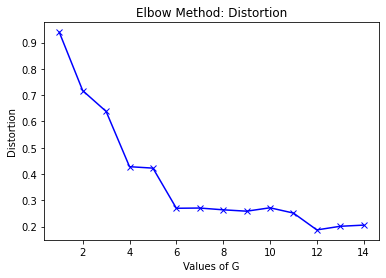

In [ ]:
plt.plot(G, distortions, 'bx-') 
plt.xlabel('Values of G') 
plt.ylabel('Distortion') 
plt.title('Elbow Method: Distortion') 
plt.show() 

In [ ]:
pca = PCA(2)
reduced_data = pca.fit_transform(data)
GMModel = GaussianMixture(n_components=3, )
GMModel.fit(reduced_data)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=3, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

In [ ]:
reduced_data.shape

(12851, 2)

In [ ]:
# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

In [ ]:
# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

In [ ]:
Z = GMModel.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

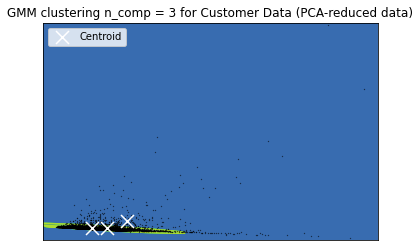

In [ ]:
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Accent,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=0.5)
# Plot the centroids as a white X
means = GMModel.means_
plt.scatter(means[:, 0], means[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10, label = "Centroid")
plt.contour(xx,yy, Z)
plt.title('GMM clustering n_comp = 3 for Customer Data (PCA-reduced data)')
plt.legend()
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

### Invoice Data

In [ ]:
invoice_data = pd.read_csv('invoice_data.csv')

In [ ]:
invoice_data

,AveragePaymentValue,CustomerKey,DueDate,EarliestPaymentDate,InvoiceKey,NumPayments,OriginalInvoiceAmount,LatestPaymentDate,PaymentType,TotalPaymentValue,RaisedDate,StatementTransactionType,IsInvoicePaidFully,RaisedToFirstPayment,RaisedToCleared,IsClearedOnTime
0,168.000,16745090,2018-03-02,2018-11-23,195519971,1.0,168.00,2018-11-23,Barclays Multi,168.00,2018-01-03,INV,1,324,324.0,0
1,819.600,16743947,2018-02-03,2018-10-26,196442471,1.0,819.60,2018-10-26,Barclays Multi,819.60,2018-01-04,INV,1,295,295.0,0
2,718.200,16836264,2018-02-08,2018-11-05,196563186,1.0,749.40,2018-11-05,Barclays Multi,718.20,2018-01-09,INV,0,300,NaN,0
3,1873.080,16843107,2018-03-02,2018-09-04,196711370,1.0,1873.08,2018-09-04,Barclays Multi,1873.08,2018-01-11,INV,1,236,236.0,0
4,1316.090,16739410,2018-02-11,2018-09-26,197134638,1.0,1316.09,2018-09-26,Barclays Multi,1316.09,2018-01-12,INV,1,257,257.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272237,24.815,16849111,2019-07-30,2019-07-30,196911580,2.0,49.63,2019-08-30,Barclays Multi,49.63,2019-06-30,INV,1,30,61.0,0
272238,178.165,16847651,2019-07-30,2019-09-24,195362531,2.0,356.33,2019-10-07,Barclays Multi,356.33,2019-06-30,INV,1,86,99.0,0
272239,36.310,16917308,2019-07-30,2019-07-29,196871858,2.0,72.62,2019-08-09,Barclays Multi,72.62,2019-06-30,INV,1,29,40.0,0
272240,311.440,16782671,2019-07-30,2019-07-22,195891626,2.0,311.44,2019-09-18,CheckM8,622.88,2019-06-30,INV,1,22,80.0,0


In [ ]:
invoice_data = invoice_data.drop(['CustomerKey'], axis = 1)

invoice_data["RaisedDate"] = pd.to_datetime(invoice_data["RaisedDate"])
invoice_data["DueDate"] = pd.to_datetime(invoice_data["DueDate"])
invoice_data["EarliestPaymentDate"] = pd.to_datetime(invoice_data["EarliestPaymentDate"])
invoice_data["LatestPaymentDate"] = pd.to_datetime(invoice_data["LatestPaymentDate"])

invoice_data = invoice_data.dropna()

In [ ]:
# Create onehot encoder
enc = OneHotEncoder(handle_unknown='ignore')

In [ ]:
# One Hot Encode Categorical Variables
# Statement Transaction Type
enc_df = pd.DataFrame(data = enc.fit_transform(invoice_data[['StatementTransactionType']]).toarray(), columns = enc.categories_)
invoice_data = invoice_data.join(enc_df)

# Payment Type
enc_df = pd.DataFrame(data = enc.fit_transform(invoice_data[['PaymentType']]).toarray(), columns = enc.categories_)
invoice_data = invoice_data.join(enc_df)

In [ ]:
invoice_data = invoice_data.drop(['PaymentType','StatementTransactionType'], axis=1)

In [ ]:
invoice_data = invoice_data.dropna()

In [ ]:
invoice_data["PaymentPercentage"] =  invoice_data["TotalPaymentValue"] / invoice_data["OriginalInvoiceAmount"]
invoice_data["PaymentTimeRemaining"] = (invoice_data["DueDate"] - invoice_data["LatestPaymentDate"]).astype('timedelta64[D]')
invoice_data["1stPaymentTimeRemaining"] = (invoice_data["DueDate"] - invoice_data["EarliestPaymentDate"]).astype('timedelta64[D]')
invoice_data["PaymentWindow"] = (invoice_data["DueDate"] - invoice_data["RaisedDate"]).astype('timedelta64[D]')

In [ ]:
invoice_data = invoice_data.drop(["DueDate", "EarliestPaymentDate", "LatestPaymentDate", "InvoiceKey", "RaisedDate"], axis=1)

In [ ]:
data = scale(invoice_data)

In [ ]:
distortions = [] 
covariances = [] 
mapping1 = {} 
mapping2 = {} 
G = range(1,15) 

# Loop 10 times
for g in G: 
    #Building and fitting the model 
    GMModel = GaussianMixture(n_components=g, ).fit(data) 
    GMModel.fit(data)     
      
    distortions.append(sum(np.min(cdist(data, GMModel.means_, 
                      'cosine'),axis=1)) / data.shape[0]) 
    covariances.append(GMModel.covariances_) 
  
    mapping1[g] = sum(np.min(cdist(data, GMModel.means_, 
                 'cosine'),axis=1)) / data.shape[0] 
    mapping2[g] = GMModel.covariances_ 

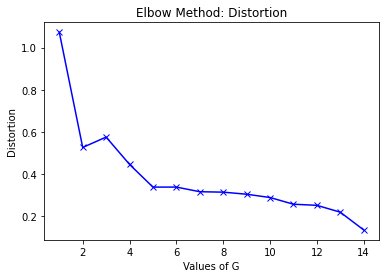

In [ ]:
plt.plot(G, distortions, 'bx-') 
plt.xlabel('Values of G') 
plt.ylabel('Distortion') 
plt.title('Elbow Method: Distortion') 
plt.show() 

In [ ]:
pca = PCA(2)
reduced_data = pca.fit_transform(data)
GMModel = GaussianMixture(n_components=3, )
GMModel.fit(reduced_data)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=3, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

In [ ]:
# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

In [ ]:
# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

In [ ]:
Z = GMModel.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

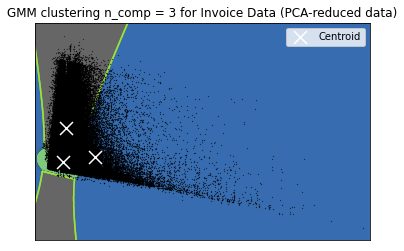

In [ ]:
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Accent,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=0.5)
# Plot the centroids as a white X
means = GMModel.means_
plt.scatter(means[:, 0], means[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10, label = "Centroid")
plt.contour(xx,yy, Z)
plt.title('GMM clustering n_comp = 3 for Invoice Data (PCA-reduced data)')
plt.legend()
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()